# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [1]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

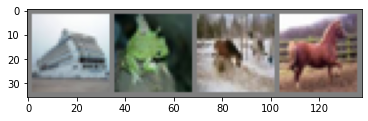

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

In [5]:
labels

tensor([8, 6, 7, 7, 6, 3, 9, 9, 5, 1, 5, 4, 3, 3, 4, 0, 3, 8, 1, 6, 7, 3, 3, 1,
        3, 5, 2, 8, 0, 4, 5, 6, 6, 0, 4, 8, 3, 8, 6, 1, 2, 3, 9, 9, 7, 6, 5, 6,
        9, 6, 5, 2, 5, 2, 4, 4, 2, 9, 7, 1, 1, 9, 8, 4])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [6]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, padding=1 )
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3, padding=1 )
        self.conv3 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=1)
        
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(32)
        
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=8)
        
        self.linear = nn.Linear(512, n_classes)
        

    def forward(self, x):

        out_skip = self.conv3(x)
        out_skip = self.batchnorm3(out_skip)
        
        out1 = self.conv1(x)
        out1 = self.batchnorm1(out1)
        out1 = self.relu(out1)

        out2 = self.conv2(out1)
        out2 = self.batchnorm2(out2)

        out3 = out_skip + out2        
        out3 = self.relu(out2)
        
        out3 = self.avgpool(out2)
        out3 = self.relu(out3)
        out = self.linear(out3.reshape(-1, 512))

        return out

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [11]:
criterion = nn.CrossEntropyLoss()

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            loss_log.append(loss.item())
        
            labels = torch.argmax(output, dim=1)
            acc = (labels==target).cpu().sum()/len(labels)
            acc_log.append(acc) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        labels = torch.argmax(output, dim=1)
       # print(labels== target)
        #print(output,labels, target)
        with torch.no_grad():
            acc = (labels==target).cpu().sum()/len(labels)
            acc_log.append(acc) 
    
    #print('sss')
    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None, verbose=True):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.append(np.mean(train_loss))
        train_acc_log.append(np.mean(train_acc))
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        if verbose:
            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()
    
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [12]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.000001, momentum=0.7)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader )

Epoch 0
 train loss: 2.2341592939505848, train acc: 0.16696999967098236
 val loss: 2.1007990674769625, val acc: 0.2521054744720459

Epoch 1
 train loss: 1.9895051903001133, train acc: 0.29572832584381104
 val loss: 1.8827806564087564, val acc: 0.3377216160297394

Epoch 2
 train loss: 1.8420939236280034, train acc: 0.35131970047950745
 val loss: 1.7882115587275078, val acc: 0.3688829839229584

Epoch 3
 train loss: 1.768717392489069, train acc: 0.37746065855026245
 val loss: 1.700782029679481, val acc: 0.40062054991722107

Epoch 4
 train loss: 1.6836171568638665, train acc: 0.40212851762771606
 val loss: 1.6508631985238258, val acc: 0.409308522939682

Epoch 5
 train loss: 1.6284406172074173, train acc: 0.4178351163864136
 val loss: 1.6051061995485996, val acc: 0.4280363619327545

Epoch 6
 train loss: 1.5840798293868628, train acc: 0.4338110685348511
 val loss: 1.561864734710531, val acc: 0.44106829166412354

Epoch 7
 train loss: 1.5475565273539458, train acc: 0.44489017128944397
 val los

Посчитайте точность на тестовой выборке:

In [13]:
test(net, test_loader)

(1.3538141250610352, 0.51711786)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')

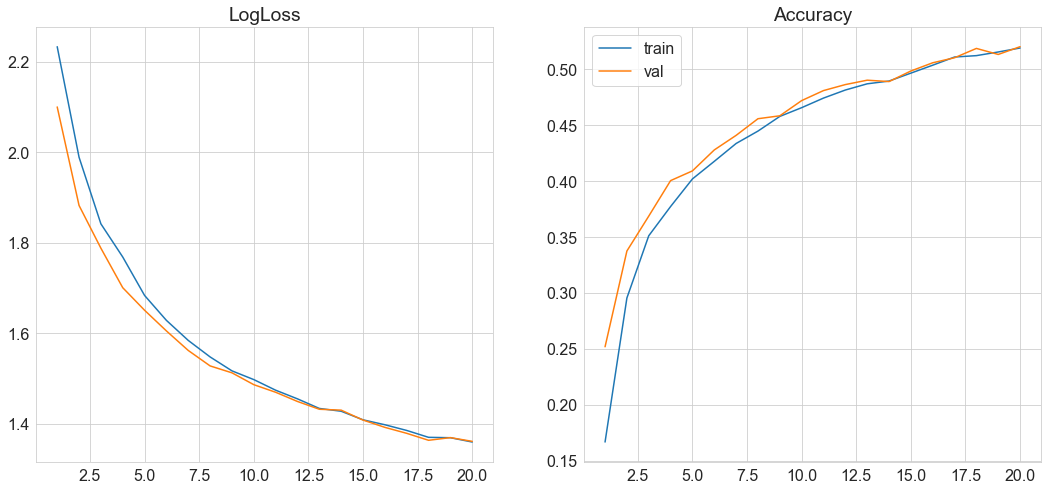

In [15]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
axes[0].plot(range(1, len(train_loss_log)+1), train_loss_log, label='train')
axes[0].plot(range(1, len(val_loss_log)+1), val_loss_log, label='val')  

axes[1].plot(range(1, len(train_acc_log)+1), train_acc_log, label='train')
axes[1].plot(range(1, len(val_acc_log)+1), val_acc_log, label='val') 

axes[0].set_title('LogLoss')
axes[1].set_title('Accuracy')

plt.legend()
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [16]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[ 10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 2.0062681222964467, train acc: 0.27933207154273987
 val loss: 1.7866979639580909, val acc: 0.3762189447879791

Epoch 1
 train loss: 1.6981255912257722, train acc: 0.40258553624153137
 val loss: 1.6244922876358032, val acc: 0.4215204119682312

Epoch 2
 train loss: 1.5909341251174536, train acc: 0.4334641993045807
 val loss: 1.5498879463114636, val acc: 0.45161789655685425

Epoch 3
 train loss: 1.5375116823796162, train acc: 0.45227620005607605
 val loss: 1.4941279639589025, val acc: 0.46917107701301575

Epoch 4
 train loss: 1.4885296324707253, train acc: 0.4674564301967621
 val loss: 1.4790125745408078, val acc: 0.46365246176719666

Epoch 5
 train loss: 1.4621493720485261, train acc: 0.47809073328971863
 val loss: 1.4515361090923877, val acc: 0.4807845652103424

Epoch 6
 train loss: 1.461119233799155, train acc: 0.4758300185203552
 val loss: 1.447324884698746, val acc: 0.48488476872444153

Epoch 7
 train loss: 1.4343270996153028, train acc: 0.48554617166519165
 val 

Посчитайте точность на тестовой выборке:

In [17]:
test(net, test_loader)

(1.3416197243010162, 0.51492834)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [18]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.0000001, momentum=0.7)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 2.300876930819133, train acc: 0.11412902176380157
 val loss: 2.2644300136160345, val acc: 0.14827127754688263

Epoch 1
 train loss: 2.215899375500583, train acc: 0.19910959899425507
 val loss: 2.1575150439079773, val acc: 0.235904261469841

Epoch 2
 train loss: 2.121954579675873, train acc: 0.24747814238071442
 val loss: 2.0793755734220465, val acc: 0.2587544322013855

Epoch 3
 train loss: 2.05504095118486, train acc: 0.2668655514717102
 val loss: 2.013843994952263, val acc: 0.2789228856563568

Epoch 4
 train loss: 1.9865288688670129, train acc: 0.2935655415058136
 val loss: 1.9521240051756514, val acc: 0.30452126264572144

Epoch 5
 train loss: 1.9357009786138586, train acc: 0.31259384751319885
 val loss: 1.90270701317077, val acc: 0.31921541690826416

Epoch 6
 train loss: 1.8864214165337125, train acc: 0.3287493586540222
 val loss: 1.8471737110868414, val acc: 0.3422207534313202

Epoch 7
 train loss: 1.8433098714573946, train acc: 0.34524762630462646
 val loss: 1.

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

**CosineAnnealingLR** Циклически снижает длину шага по кривой косинуса, за все время обучения происходит несколько таких циклов. Позволяет находить несколько локальных минимумов. В нашем случае будем только снижать значение длины шага, установив T_max=num_epochs 

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer,20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 2.013983439701785, train acc: 0.2754594683647156
 val loss: 1.835824085803742, val acc: 0.3581560552120209

Epoch 1
 train loss: 1.7356505579224888, train acc: 0.3834633529186249
 val loss: 1.6467694769514367, val acc: 0.42118796706199646

Epoch 2
 train loss: 1.6271633463324315, train acc: 0.4244377017021179
 val loss: 1.5921198910855232, val acc: 0.43652480840682983

Epoch 3
 train loss: 1.5574327604862193, train acc: 0.4446249008178711
 val loss: 1.5287530822956816, val acc: 0.458776593208313

Epoch 4
 train loss: 1.4981988812277478, train acc: 0.4595276117324829
 val loss: 1.4734933868367621, val acc: 0.47025710344314575

Epoch 5
 train loss: 1.4624903762144406, train acc: 0.4725082814693451
 val loss: 1.455820586833548, val acc: 0.47958776354789734

Epoch 6
 train loss: 1.4548910128351102, train acc: 0.48099619150161743
 val loss: 1.4381629345264841, val acc: 0.48672425746917725

Epoch 7
 train loss: 1.4306139780354892, train acc: 0.4871009290218353
 val loss:

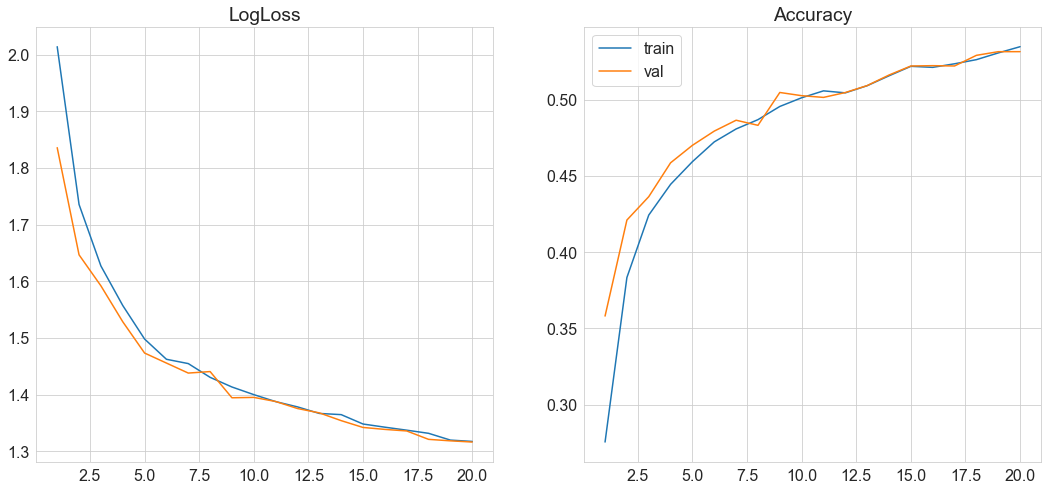

In [20]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
axes[0].plot(range(1, len(tr_loss_log)+1), tr_loss_log, label='train')
axes[0].plot(range(1, len(val_loss_log)+1), val_loss_log, label='val')  

axes[1].plot(range(1, len(tr_acc_log)+1), tr_acc_log, label='train')
axes[1].plot(range(1, len(val_acc_log)+1), val_acc_log, label='val') 

axes[0].set_title('LogLoss')
axes[1].set_title('Accuracy')

plt.legend()
plt.show()

In [21]:
test(net, test_loader)

(1.320576164373167, 0.53055334)

**CyclicLR**: Также циклически снижает длину шага, однако делает одинаковые шаги, в отличие от  предыдущего метода. Чтобы увидеть, как работает этот метод, будем использовать 45 эпох для обучения.

In [22]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.CyclicLR(optimizer,  step_size_up=5, step_size_down=10, base_lr=0.0000001, max_lr=0.00001)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 45, train_loader, val_loader, 
                                                           scheduler, verbose=False)

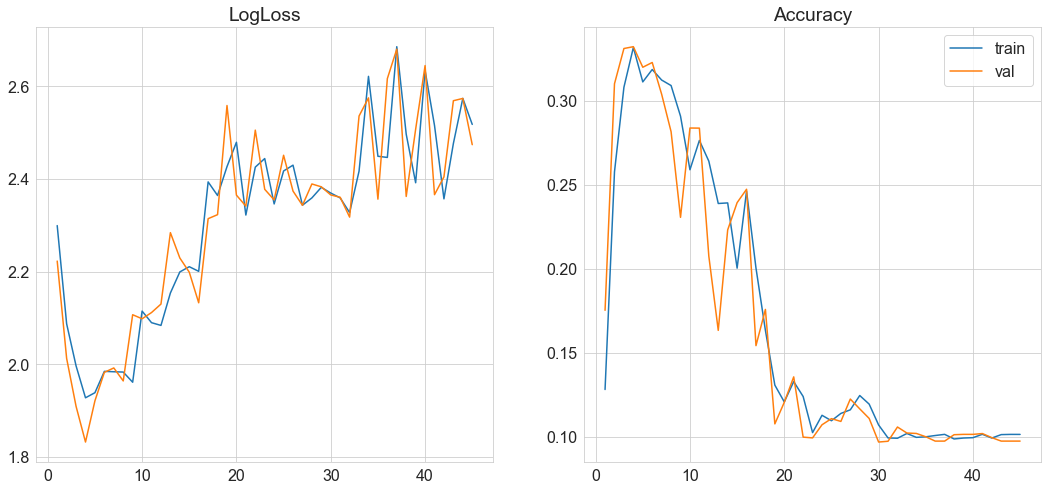

In [23]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
axes[0].plot(range(1, len(tr_loss_log)+1), tr_loss_log, label='train')
axes[0].plot(range(1, len(val_loss_log)+1), val_loss_log, label='val')  

axes[1].plot(range(1, len(tr_acc_log)+1), tr_acc_log, label='train')
axes[1].plot(range(1, len(val_acc_log)+1), val_acc_log, label='val') 

axes[0].set_title('LogLoss')
axes[1].set_title('Accuracy')

plt.legend()
plt.show()

In [24]:
test(net, test_loader)

(2.466452521123704, 0.09952229)

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

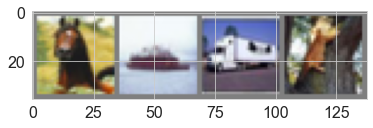

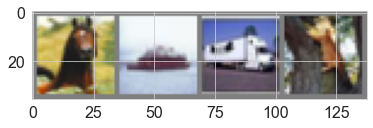

In [25]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [26]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, 
                                                           scheduler, verbose=False)

Files already downloaded and verified
Files already downloaded and verified


Посчитайте точность на тестовой выборке:

In [27]:
test(net, test_loader)

(1.3493875447352222, 0.5166202)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomErasing** стирает случайную область картинки, заполняет эту область случайным набором пикселей.

Files already downloaded and verified
Files already downloaded and verified


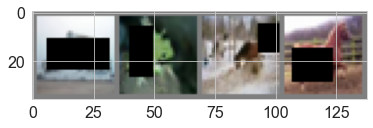

In [28]:
transform = transforms.Compose(
    
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.RandomErasing(p=1),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

In [29]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, 
                                                           scheduler, verbose=False)

In [30]:
test(net, test_loader)

(1.4221013397168203, 0.4942277)

**ColorJitter** Случайно регулирует яркость, контрастность, насыщенность, оттенки картинки

Files already downloaded and verified
Files already downloaded and verified


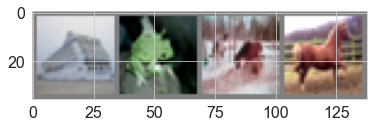

In [31]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness = 0.2, contrast= 0.5, saturation = 1.5,
                                hue = 0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

In [32]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, 
                                                           scheduler, verbose=False)

In [33]:
test(net, test_loader)

(1.3801270032384594, 0.51054937)

**RandomPerspective** случайно меняет перспективу картинки

Files already downloaded and verified
Files already downloaded and verified


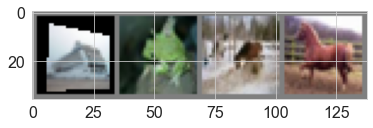

In [34]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomPerspective(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

In [35]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, 
                                                           scheduler, verbose=False)

In [36]:
test(net, test_loader)

(1.4002508471725852, 0.49482483)

Files already downloaded and verified
Files already downloaded and verified


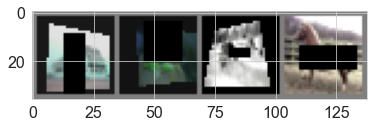

In [38]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomPerspective(),
         transforms.ColorJitter(brightness = 0.2, contrast= 0.5, saturation = 1.5, 
                                hue = 0.1),
         transforms.ToTensor(),
         transforms.RandomErasing(p=1),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))

In [39]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.7)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, 
                                                           scheduler, verbose=False)

In [40]:
test(net, test_loader)

(1.5371810843230813, 0.4522293)

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>